# K-Nearest Neighbors, with cuML

In [1]:
import cudf

df = cudf.read_csv('https://github.com/gumdropsteve/datasets/raw/master/iris.csv')

In [2]:
df

,sepal_length,sepal_width,petal_length,petal_width,species,target
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,2
146,6.3,2.5,5.0,1.9,virginica,2
147,6.5,3.0,5.2,2.0,virginica,2
148,6.2,3.4,5.4,2.3,virginica,2


In [3]:
df.species.unique()

0        setosa
1    versicolor
2     virginica
Name: species, dtype: object

#### Data Prep

Before we get too far ahead of ourselves, we should split our data into training and testing datasets. This allows us to test our model with actual data that the model has never seen.

In [4]:
from cuml.preprocessing.model_selection import train_test_split

df = df.drop('species')

X_train, X_test, y_train, y_test = train_test_split(df, 'target', train_size=0.8)


Often you will need to cluster that data (our data has already been clustered because we know the species of each recorded flower).
- This can be done a number of ways including [PCA](https://github.com/gumdropsteve/cuml_pca) and [K-Means](https://github.com/gumdropsteve/cuml_kmeans) clustering.

Let's convert our cudf.DataFrame `.to_pandas()` to easily visualize a our clusters with Matplotlib.

/home/winston/anaconda3/envs/bsql-0.14/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/winston/anaconda3/envs/bsql-0.14/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/winston/anaconda3/envs/bsql-0.14/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.co

<AxesSubplot:xlabel='sepal_length', ylabel='petal_width'>

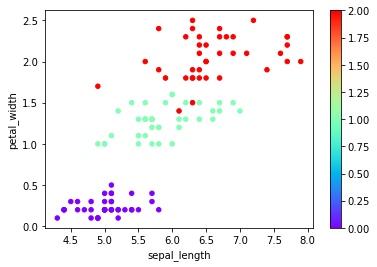

In [5]:
X_train.to_pandas().plot(kind='scatter', x='sepal_length', y='petal_width',
                         c=y_train.to_array(), cmap=('rainbow'), sharex=False)

#### Step 2: Add a new cell, with unknown category, to the PCA plot. 
- We don't know this cell's category because it was taken from another tumor where the cells were not properly sorted.

In [6]:
from matplotlib import pyplot as plt

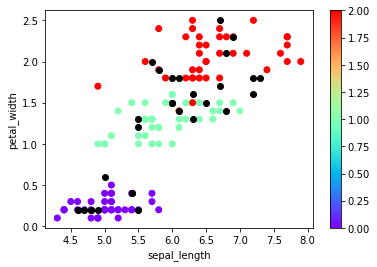

In [7]:
plt.xlabel('sepal_length'), plt.ylabel('petal_width')

# scatter training dataset (rainbow) + colorbar
plt.scatter(x=X_train['sepal_length'].to_pandas(), y=X_train['petal_width'].to_pandas(),
            c=y_train.to_pandas(), cmap='rainbow')
plt.colorbar()

# scatter testing dataset (black)
plt.scatter(x=X_test['sepal_length'].to_pandas(), y=X_test['petal_width'].to_pandas(),
            color='k')

#### Step 3: We classify the new cell by looking at the nnew_samplest anticipated cells. (i.e. the "nearest neighbors").
- If the "K" in "K-nearest neighbors" is equal to 1, then we only use the nearest neighbor to define the category. In this case, the category is GREEN. If K=11, we would use the 11 nearest neighbors. 
- In this case, the category is still GREEN. 
- Now the new cell is somewhere more interesting.. 
    - If k=11 and the new cell is between two (or more) categories, we simply pick the category that "gets the most votes". 
    - In this case… 7 nearest neighbors are RED, 3 nearest neighbors are ORANGE, 1 nearest neighbor is GREEN. Since RED got the most votes, the final assignment is RED. 

## K-Nearest Neighbors Classification vs Regression

### **Classifier**

K-Nearest Neighbors Classifier is an instance-based learning technique,
that keeps training samples around for prediction, rather than trying
to learn a generalizable set of model parameters.

In [8]:
from cuml.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

In [9]:
knn.fit(X_train, y_train)

KNeighborsClassifier(weights='uniform')

In [10]:
results = knn.predict(X_test)

results.tail(3)

27    2
28    1
29    0
dtype: int32

In [11]:
df = X_test.copy()

df['actual'] = y_test.values
df['predicted'] = results.values

df.tail()

,sepal_length,sepal_width,petal_length,petal_width,actual,predicted
145,6.3,3.3,4.7,1.6,1,1
146,5.5,3.5,1.3,0.2,0,0
147,6.1,3.0,4.9,1.8,2,2
148,6.3,2.3,4.4,1.3,1,1
149,4.9,3.0,1.4,0.2,0,0


#### Classifier Results

In [12]:
n_correct = len(df.loc[df['actual']==df['predicted']])
n_possible = len(df)

print(f'{n_correct} / {n_possible} correct\n{str(n_correct / n_possible)[:5]}% accuracy')

29 / 30 correct
0.966% accuracy


In [13]:
df_correct = df.loc[df['actual'] == df['predicted']]
df_incorrect = df.loc[df['actual'] != df['predicted']]

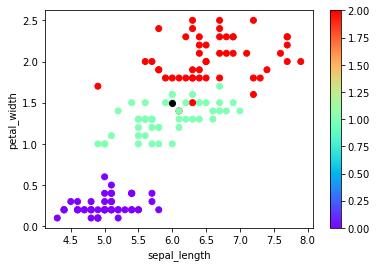

In [14]:
plt.xlabel('sepal_length'), plt.ylabel('petal_width')

# plot training instances (rainbow) + colorbar
plt.scatter(x=X_train['sepal_length'].to_pandas(), y=X_train['petal_width'].to_pandas(),
            c=y_train.to_pandas(), cmap='rainbow')
plt.colorbar()

# plot correctly predicted instances (rainbow)
plt.scatter(x=df_correct['sepal_length'].to_pandas(), y=df_correct['petal_width'].to_pandas(),
            c=df_correct['actual'].to_pandas(), cmap='rainbow')

# plot incorrectly predicted instances (black) (except if cudf.Series)
try:
    plt.scatter(x=df_incorrect['sepal_length'].to_pandas(), y=df_incorrect['petal_width'].to_pandas(), color='k')
except:
    plt.scatter(x=df_incorrect['sepal_length'], y=df_incorrect['petal_width'], color='k')

In [15]:
df_incorrect

sepal_length    6.0
sepal_width     2.2
petal_length    5.0
petal_width     1.5
actual          2.0
predicted       1.0
Name: 135, dtype: float64

### **Regressor**

K-Nearest Neighbors Regressor is an instance-based learning technique,
that keeps training samples around for prediction, rather than trying
to learn a generalizable set of model parameters.

The K-Nearest Neighbors Regressor will compute the average of the
labels for the k closest neighbors and use it as the label.

In [16]:
from cuml.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=3)

In [17]:
knn.fit(X_train, y_train)

KNeighborsRegressor(weights='uniform')

In [18]:
results = knn.predict(X_test)

results.tail(3)

27    1.666667
28    1.000000
29    0.000000
dtype: float32

In [19]:
df = X_test.copy()

df['actual'] = y_test.values
df['predicted'] = results.values

df.tail()

,sepal_length,sepal_width,petal_length,petal_width,actual,predicted
145,6.3,3.3,4.7,1.6,1,1.000000
146,5.5,3.5,1.3,0.2,0,0.000000
147,6.1,3.0,4.9,1.8,2,1.666667
148,6.3,2.3,4.4,1.3,1,1.000000
149,4.9,3.0,1.4,0.2,0,0.000000


#### Regressor Results

In [20]:
n_correct = len(df.loc[df['actual']==df['predicted']])
n_possible = len(df)

print(f'{n_correct} / {n_possible} correct\n{str(n_correct / n_possible)[:5]}% accuracy')

26 / 30 correct
0.866% accuracy


In [21]:
df_correct = df.loc[df['actual'] == df['predicted']]
df_incorrect = df.loc[df['actual'] != df['predicted']]

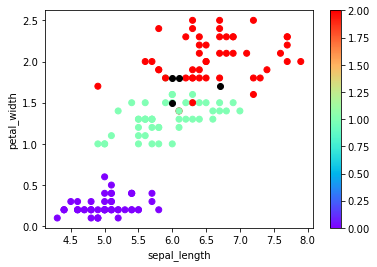

In [22]:
plt.xlabel('sepal_length'), plt.ylabel('petal_width')

# plot training instances (rainbow) + colorbar
plt.scatter(x=X_train['sepal_length'].to_pandas(), y=X_train['petal_width'].to_pandas(),
            c=y_train.to_pandas(), cmap='rainbow')
plt.colorbar()

# plot correctly predicted instances (rainbow)
plt.scatter(x=df_correct['sepal_length'].to_pandas(), y=df_correct['petal_width'].to_pandas(),
            c=df_correct['actual'].to_pandas(), cmap='rainbow')

# plot incorrectly predicted instances (black)
plt.scatter(x=df_incorrect['sepal_length'].to_pandas(), y=df_incorrect['petal_width'].to_pandas(), color='k')

In [23]:
df_incorrect

,sepal_length,sepal_width,petal_length,petal_width,actual,predicted
127,6.7,3.0,5.0,1.7,1,1.333333
132,6.0,3.0,4.8,1.8,2,1.666667
135,6.0,2.2,5.0,1.5,2,1.000000
147,6.1,3.0,4.9,1.8,2,1.666667


## Nearest Neighbors
Before we wrap up K-Nearest Neighbors, we should get familiar with the Nearest Neighbors algorithm, which enables the query of the K-Nearest Neighbors from a set of input samples.

In [24]:
from cuml.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=3)

In [25]:
X = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

X.tail(3)

,sepal_length,sepal_width,petal_length,petal_width
147,6.1,3.0,4.9,1.8
148,6.3,2.3,4.4,1.3
149,4.9,3.0,1.4,0.2


Pass features and labels into model, then calculate the nearest neighbors at k=3.

In [26]:
knn.fit(X)

NearestNeighbors(n_neighbors=3, verbose=2, handle=<cuml.common.handle.Handle object at 0x7fa77c856e30>, algorithm='brute', metric='euclidean', output_type='cudf')

cuML's `.kneighbors()` model returns a tuple with 2 cudf.DataFrames holding the *distances* and *indices* of the k-nearest neighbors for each column vector in X.

In [27]:
distances, indicies = knn.kneighbors(X, n_neighbors=3)

In [28]:
distances.tail(3)

,0,1,2
27,0.0,0.141409,0.458257
28,0.0,0.608291,0.707101
29,0.0,0.346414,0.360562


In [29]:
indicies.tail(3)

,0,1,2
27,27,12,25
28,28,0,15
29,29,8,18


# Continued Learning 
Here are some resources I recommend to help fill in any gaps and provide a more complete picture.

#### **StatQuest: K-nearest neighbors, Clearly Explained**
- Watch on YouTube: [https://youtu.be/HVXime0nQeI](https://youtu.be/HVXime0nQeI)
- Channel: StatQuest with Josh Starmer ([Subscribe](https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw?sub_confirmation=1))

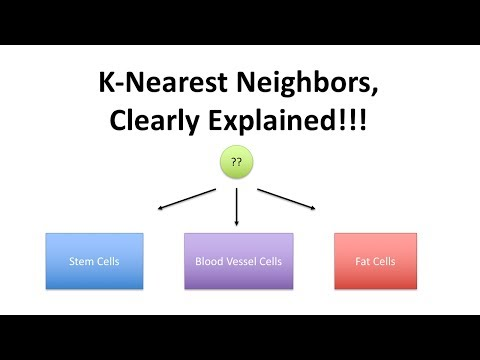

In [30]:
from IPython.display import YouTubeVideo
YouTubeVideo('HVXime0nQeI', width=(1280*0.69), height=(720*0.69))

#### **_k_-nearest neighbors algorithm**
Wikipedia: [https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

#### **Nearest Neighbour Algorithm - Part 1**
- Watch on YouTube: [https://youtu.be/JH2IUFmP8JI](https://youtu.be/JH2IUFmP8JI)
- Channel: Darren Barton ([Subscribe](https://www.youtube.com/user/bartondeb1?sub_confirmation=1))

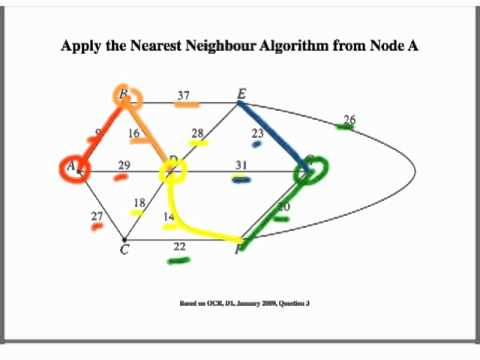

In [31]:
from IPython.display import YouTubeVideo
YouTubeVideo('JH2IUFmP8JI', width=720, height=480)

#### **Nearest neighbour algorithm**
Wikipedia: [https://en.wikipedia.org/wiki/Nearest_neighbour_algorithm](https://en.wikipedia.org/wiki/Nearest_neighbour_algorithm) 